<ipython-input-2-60dcca79f3da>:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start=start_date, end=end_date, freq='H')
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Temperature dataset created successfully.
Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0216
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0197
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0190
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0187
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0193
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0182
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0184
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0186
Epoch 9/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0185
Epoch 10/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0182
Training Loss: 0.018295055255293846, Testing Loss: 0.01829257607460022
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

<ipython-input-2-60dcca79f3da>:88: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start=last_timestamp, periods=num_forecasts + 1, freq='H', tz=timezone.utc)[1:]


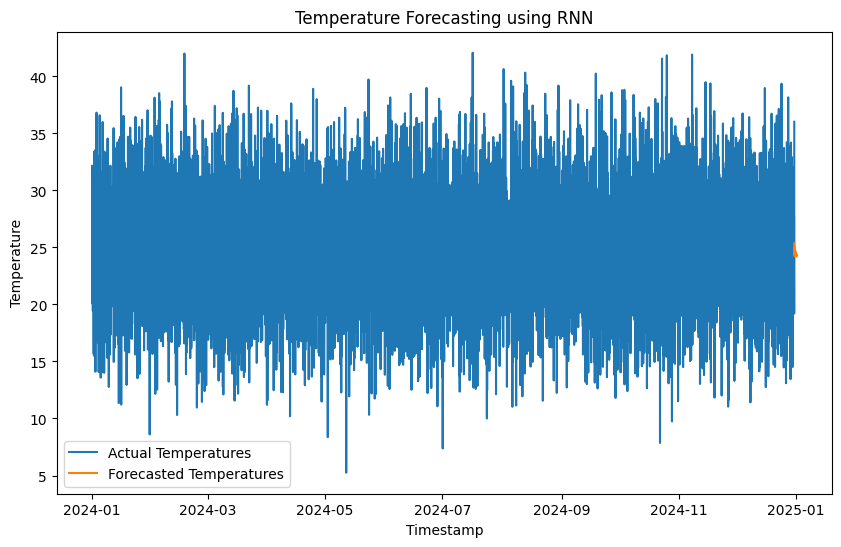

In [ ]:
#Practical No 9
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

# Define start and end dates
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 12, 31)

# Generate timestamps
timestamps = pd.date_range(start=start_date, end=end_date, freq='H')

# Generate synthetic temperature values
mean_temp = 25  # Mean temperature
temp_variation = 5  # Variation in temperature
temperature = np.random.normal(loc=mean_temp, scale=temp_variation, size=len(timestamps))

# Create DataFrame
temperature_data = pd.DataFrame({'timestamp': timestamps, 'temperature': temperature})

# Save to CSV
temperature_data.to_csv('/content/temperature.csv', index=False)
print("Temperature dataset created successfully.")

# Load the dataset
data = pd.read_csv('/content/temperature.csv')

# Convert timestamp column to datetime object and localize it to UTC timezone
data['timestamp'] = pd.to_datetime(data['timestamp']).dt.tz_localize(timezone.utc)

# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['temperature'].values.reshape(-1, 1))

# Split data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create sequences for input data
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Length of input sequence
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape input sequences to match the required dimensions
X_train = X_train.reshape(-1, seq_length, 1)
X_test = X_test.reshape(-1, seq_length, 1)

# Define and train the RNN model
model = Sequential([
    SimpleRNN(units=50, input_shape=(seq_length, 1)),
    Dense(units=1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Training Loss: {train_loss}, Testing Loss: {test_loss}')

# Forecasting
def forecast(model, data, seq_length, num_forecasts):
    forecasts = []
    current_seq = data.reshape(1, seq_length, 1)
    for i in range(num_forecasts):
        next_pred = model.predict(current_seq)[0][0]
        forecasts.append(next_pred)
        current_seq = np.insert(current_seq, current_seq.shape[1], next_pred, axis=1)
    return forecasts

num_forecasts = 30  # Number of future temperature forecasts
future_forecasts = forecast(model, scaled_data[-seq_length:], seq_length, num_forecasts)

# Generating future dates
last_timestamp = pd.to_datetime(data['timestamp'].iloc[-1])
future_dates = pd.date_range(start=last_timestamp, periods=num_forecasts + 1, freq='H', tz=timezone.utc)[1:]

# Inverse transform the scaled data
future_forecasts = scaler.inverse_transform(np.array(future_forecasts).reshape(-1, 1))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(data['timestamp'], data['temperature'], label='Actual Temperatures')
plt.plot(future_dates, future_forecasts, label='Forecasted Temperatures')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.title('Temperature Forecasting using RNN')
plt.legend()
plt.show()